### installs

In [ ]:
!pip install numpy==1.25.2 --force-reinstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 40.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.25.2 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.25.2 which is incompatible.
blosc2 3.3.4 requires numpy>=1.26, but you have numpy 1.25.2 which is incompatible.


In [4]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 19.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


### imports

In [ ]:
import re
import string
import gensim
from nltk.tokenize.treebank import TreebankWordDetokenizer
import spacy
import pandas as pd
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Embedding

from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd


### functions

In [ ]:
def clean_tweet(text):

  #remove urls and emails
  url_pattern=re.compile(r'https?://\S+|www\.\S+')
  text=url_pattern.sub(r'',text)

  email_pattern=re.compile(r'\S+@\S+\.com')
  text=email_pattern.sub(r'',text)

  #remove @s
  text=re.sub(r'@\w+','',text)

  #remove hashtags
  text=re.sub(r'#','',text)

  #remove numbers
  text=re.sub(r'\d+','',text)

  #clean the extra spaces
  text=re.sub(r'\s+', ' ', text).strip()

  return text

In [ ]:
def tokenize(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence),deacc=True))

In [ ]:
def detokenize(text):
  if text:
    return TreebankWordDetokenizer().detokenize(text)
  else:
    return ''

In [ ]:
nlp=spacy.load('en_core_web_sm')

def lemmatize(text):
  lemmatized_text=[]
  for doc in nlp.pipe(text,batch_size=500,n_process=3):
    lemmatized_text.append(' '.join([token.lemma_ for token in doc]))
  return lemmatized_text

### preparation

In [ ]:
train_df=pd.read_csv('twitter_training.csv')
test_df=pd.read_csv('twitter_validation.csv')

In [14]:
train_df.columns=['id','entity','sentiment','content']
test_df.columns=['id','entity','sentiment','content']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


# Save
#with open('/content/drive/MyDrive/lemmatized_train.pkl', 'wb') as f:
#    pickle.dump(lemmatized_train, f)

#with open('/content/drive/MyDrive/lemmatized_test.pkl', 'wb') as f:
#    pickle.dump(lemmatized_test, f)

# Load
with open('/content/drive/MyDrive/lemmatized_train.pkl', 'rb') as f:
    lemmatized_train = pickle.load(f)

with open('/content/drive/MyDrive/lemmatized_test.pkl', 'rb') as f:
    lemmatized_test = pickle.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
#clean training
train_df = train_df.dropna(subset=['content'])

temp_train=[]
data_to_list_train=train_df['content'].tolist()
for i in data_to_list_train:
  temp_train.append(clean_tweet(i))

#lemmatized_train=lemmatize(temp_train)

data_words_train=list(tokenize(lemmatized_train))

data_train=[]
for i in data_words_train:
  data_train.append(detokenize(i))

#clean test
test_df = test_df.dropna(subset=['content'])

temp_test=[]
data_to_list_test=test_df['content'].tolist()
for i in data_to_list_test:
  temp_test.append(clean_tweet(i))

#lemmatized_test=lemmatize(temp_test)

data_words_test=list(tokenize(lemmatized_test))

data_test=[]
for i in data_words_test:
  data_test.append(detokenize(i))

print(data_train)

['be come to the border and will kill you all', 'get on borderland and will kill you all', 'come on borderland and will murder you all', 'get on borderland and will murder you all', 'get into borderland and can murder you all', 'so spend few hour make something for fun if you do not know be huge fan and maya be one of my favorite character so decide to make myself wallpaper for my pc here be the original image versus the creation make enjoy pic twitter com mlsiwfjg', 'so spend couple of hour do something for fun if you do not know that be huge borderlands fan and maya be one of my favorite character decide to make wallpaper for my pc here be the original picture compare to the creation make have fun pic twitter com mlsiwfjg', 'so spend few hour do something for fun if you do not know be huge borderlands fan and maya be one of my favorite character', 'so spend few hour make something for fun if you do not know be huge rhandlerr fan and maya be one of my favorite character so decide to m

In [ ]:
max_words=5000
max_len=200

tokenizer=Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_train)

sequences_train=tokenizer.texts_to_sequences(data_train)
sequences_test=tokenizer.texts_to_sequences(data_test)

padded_train=pad_sequences(sequences_train,maxlen=max_len)
padded_test=pad_sequences(sequences_test,maxlen=max_len)

print(padded_train)

[[   0    0    0 ...  185   11   24]
 [   0    0    0 ...  185   11   24]
 [   0    0    0 ... 1284   11   24]
 ...
 [   0    0    0 ...   16   12  932]
 [   0    0    0 ...  137 1495  932]
 [   0    0    0 ...   16   12  932]]


In [ ]:
embedding_layer=Embedding(max_words,50)

### LSTM

In [23]:
model1= Sequential()
model1.add(layers.Embedding(max_words,20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(4,activation='softmax'))
model1.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
checkpoint1=ModelCheckpoint('model1.keras',monitor='val_accuracy',verbose=1,save_best_only=True,mode='auto',save_freq=1,save_weights_only=False)

history=model1.fit(padded_train,pd.get_dummies(train_df['sentiment']),epochs=10,validation_data=(padded_test,pd.get_dummies(test_df['sentiment'])),callbacks=[checkpoint1])

Epoch 1/10
   3/2313 ━━━━━━━━━━━━━━━━━━━━ 2:50 74ms/step - accuracy: 0.2865 - loss: 1.3861

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:202: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


2313/2313 ━━━━━━━━━━━━━━━━━━━━ 205s 87ms/step - accuracy: 0.4275 - loss: 1.2597 - val_accuracy: 0.6286 - val_loss: 0.9290
Epoch 2/10
   3/2313 ━━━━━━━━━━━━━━━━━━━━ 3:34 93ms/step - accuracy: 0.4653 - loss: 1.1429

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:202: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


2313/2313 ━━━━━━━━━━━━━━━━━━━━ 205s 88ms/step - accuracy: 0.5857 - loss: 1.0198 - val_accuracy: 0.6867 - val_loss: 0.8340
Epoch 3/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 258s 87ms/step - accuracy: 0.6233 - loss: 0.9487 - val_accuracy: 0.7067 - val_loss: 0.7675
Epoch 4/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 201s 86ms/step - accuracy: 0.6379 - loss: 0.9119 - val_accuracy: 0.7347 - val_loss: 0.7260
Epoch 5/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 204s 87ms/step - accuracy: 0.6504 - loss: 0.8834 - val_accuracy: 0.7477 - val_loss: 0.6870
Epoch 6/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 201s 87ms/step - accuracy: 0.6662 - loss: 0.8522 - val_accuracy: 0.7457 - val_loss: 0.6711
Epoch 7/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 201s 87ms/step - accuracy: 0.6747 - loss: 0.8336 - val_accuracy: 0.7568 - val_loss: 0.6626
Epoch 8/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 202s 87ms/step - accuracy: 0.6806 - loss: 0.8207 - val_accuracy: 0.7618 - val_loss: 0.6385
Epoch 9/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 203s 88ms/step - accuracy: 0.6840 - lo

### Bidirectional

In [24]:
model2=Sequential()
model2.add(layers.Embedding(max_words,20,input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(15,dropout=0.5)))
model2.add(layers.Dense(4,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
checkpoint2=ModelCheckpoint('model2.keras',monitor='val_accuracy',verbose=1,save_best_only=True,mode='auto',save_freq=1,save_weights_only=False)

history=model2.fit(padded_train,pd.get_dummies(train_df['sentiment']),epochs=10,validation_data=(padded_test,pd.get_dummies(test_df['sentiment'])),callbacks=[checkpoint2])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
   2/2313 ━━━━━━━━━━━━━━━━━━━━ 4:50 126ms/step - accuracy: 0.2266 - loss: 1.3882

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:202: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


2313/2313 ━━━━━━━━━━━━━━━━━━━━ 351s 150ms/step - accuracy: 0.4315 - loss: 1.2543 - val_accuracy: 0.6316 - val_loss: 0.9264
Epoch 2/10
   1/2313 ━━━━━━━━━━━━━━━━━━━━ 22:58:00 36s/step - accuracy: 0.4688 - loss: 1.1811

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:202: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


2313/2313 ━━━━━━━━━━━━━━━━━━━━ 375s 147ms/step - accuracy: 0.5853 - loss: 1.0186 - val_accuracy: 0.6767 - val_loss: 0.8590
Epoch 3/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 382s 147ms/step - accuracy: 0.6176 - loss: 0.9583 - val_accuracy: 0.7037 - val_loss: 0.7831
Epoch 4/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 383s 147ms/step - accuracy: 0.6435 - loss: 0.9080 - val_accuracy: 0.7247 - val_loss: 0.7323
Epoch 5/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 383s 148ms/step - accuracy: 0.6512 - loss: 0.8882 - val_accuracy: 0.7357 - val_loss: 0.7059
Epoch 6/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 384s 149ms/step - accuracy: 0.6605 - loss: 0.8634 - val_accuracy: 0.7377 - val_loss: 0.6840
Epoch 7/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 385s 150ms/step - accuracy: 0.6750 - loss: 0.8339 - val_accuracy: 0.7508 - val_loss: 0.6616
Epoch 8/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 378s 148ms/step - accuracy: 0.6792 - loss: 0.8220 - val_accuracy: 0.7518 - val_loss: 0.6427
Epoch 9/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 341s 148ms/step - accuracy: 0.6

### 1D convolutional neural networks

In [29]:
model3=Sequential()
model3.add(layers.Embedding(max_words,20,input_length=max_len))
model3.add(layers.Conv1D(20,6,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20,6,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(4,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

history=model3.fit(padded_train,pd.get_dummies(train_df['sentiment']),epochs=10,validation_data=(padded_test,pd.get_dummies(test_df['sentiment'])))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.3036 - loss: 1.4550 - val_accuracy: 0.2773 - val_loss: 1.3782
Epoch 2/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - accuracy: 0.2982 - loss: 1.3719 - val_accuracy: 0.2663 - val_loss: 1.3786
Epoch 3/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.3015 - loss: 1.3718 - val_accuracy: 0.2663 - val_loss: 1.3788
Epoch 4/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.2997 - loss: 1.3725 - val_accuracy: 0.2663 - val_loss: 1.3774
Epoch 5/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - accuracy: 0.3025 - loss: 1.3718 - val_accuracy: 0.2663 - val_loss: 1.3776
Epoch 6/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.3008 - loss: 1.3729 - val_accuracy: 0.2663 - val_loss: 1.3786
Epoch 7/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.3025 - loss: 1.3712 - val_accuracy: 0.2663 - val_loss: 1.3767
Epoch 8/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.3017 -

### validation

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


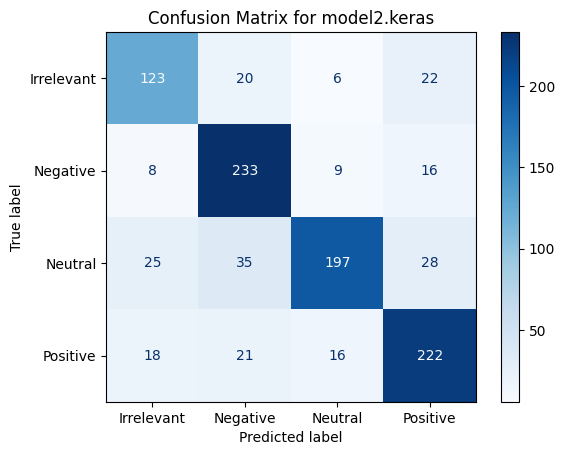

In [ ]:
check_model=model2
y_predicted_prob=check_model.predict(padded_test)
y_predicted=np.argmax(y_predicted_prob,axis=1)
y_true=np.argmax(pd.get_dummies(test_df['sentiment'].values),axis=1)

cm=confusion_matrix(y_true,y_predicted)
labels=sorted(test_df['sentiment'].unique())
display=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for model2.keras")
plt.show()